iタスク,anyモデルについて可視化する関数を用意する  
データのpathはこの階層のconfigに用意しておく
モデルの設定を上手くやるとepochの増加に対する精度の比較が楽にやれる  
これを全タスクについてやる上位関数を作る  
所定のパス(この階層のconfig)に画像を保存する関数を別に用意しておく  

In [10]:
import os, sys
import json
PATH_CUR = os.path.dirname(os.path.realpath("__file__"))
sys.path.append(PATH_CUR)
with __import__('importnb').Notebook(): 
    from score_store import ScoreStoringLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



[taskid] -> [modelname] -> [epoch,acc] という並び替えにしたい

In [11]:
def get_multiSSasDF(readSS_config,fileid_str_list):
    dir_data_dic ={}
    for dirname in readSS_config["read_directories"]:
        ssl=ScoreStoringLoader(dirname,readSS_config["filename_common"],fileid_str_list,vals=["step","bitError"])
        dir_data_dic[dirname] =ssl.get_data_dic()
    df=pd.DataFrame(dir_data_dic).reindex(index=fileid_str_list)
    return df

In [12]:
class BaselinesLoader(): 
    #data_config["savescore_dir"],data_config["filename_common"]
    def __init__(self,filename_list,baseline_dir="/work/handmade_utils/sotsuron_scores/baseline_scores",desc_lines=1,sep=":",vals=["taskid","accuracy"]):
        self.desc_lines =desc_lines
        self.sep=sep
        print("read_baseline_files:",filename_list)

        self.filename_list =filename_list
        self.data_dic={} 

        self.filepath_dic ={}
        for filename in filename_list:
            self.filepath_dic[filename] =os.path.join(baseline_dir,filename+".txt")

        for filename,path in self.filepath_dic.items():
            with open(path, "r" , encoding= "utf-8" ) as f:
                lines=f.read().splitlines()[self.desc_lines:]
                listed_data = [line.split(self.sep) for line in lines] #[["mean" , "0.83"], ...]
                self.data_dic[filename] ={line[0]:float(line[1]) for line in listed_data} #{"mean" : 0.83 , "1": ...}

    def get_data_dic(self): 
        return self.data_dic

MAIN

In [17]:
with open("./config_sotsuron.json", "r") as fp:
    config = json.load(fp)
readSS_config=config["read_ScoreStoring"]
vis_config =config["visualization"]
baseline_config =vis_config["baselines"]

#fileid_str_list =[str(i) for i in range(1,21)]
#fileid_str_list.append("mean")
#fileid_str_list =["","2","_Adam_clip50"]
fileid_str_list=readSS_config["fileid_list"]

accSequence_df =get_multiSSasDF(readSS_config,fileid_str_list)
accSequence_df

read_filename_ids: ['adam50', 'adam50c20', 'rrnn', 'rrnn_sort']


,ntm_vlgiitr
adam50,"{'step': [0.0, 200.0, 400.0, 600.0, 800.0, 100..."
adam50c20,"{'step': [0.0, 200.0, 400.0, 600.0, 800.0, 100..."
rrnn,"{'step': [0.0, 200.0, 400.0, 600.0, 800.0, 100..."
rrnn_sort,"{'step': [0.0, 200.0, 400.0, 600.0, 800.0, 100..."


In [14]:
'''for task,data in accSequence_df.iterrows():
    print(type(data),data)  # <class 'pandas.core.frame.Pandas'>
    print(data["SAM+dnc_model"])
    if task=="2":break'''
baselinesloader =BaselinesLoader(baseline_config["filenames"])
bases =baselinesloader.get_data_dic()
print(bases)

read_baseline_files: ['dnc_grave', 'lstm_grave']
{'dnc_grave': {'1': 0.91, '2': 0.608, '3': 0.604, '4': 0.996, '5': 0.985, '6': 0.9309999999999999, '7': 0.902, '8': 0.945, '9': 0.9229999999999999, '10': 0.904, '11': 0.9670000000000001, '12': 0.95, '13': 0.9690000000000001, '14': 0.89, '15': 0.728, '16': 0.46399999999999997, '17': 0.6759999999999999, '18': 0.958, '19': 0.35400000000000004, '20': 1.0, 'mean': 0.833}, 'lstm_grave': {'1': 0.716, '2': 0.44, '3': 0.487, '4': 0.992, '5': 0.968, '6': 0.848, '7': 0.836, '8': 0.823, '9': 0.846, '10': 0.713, '11': 0.878, '12': 0.946, '13': 0.928, '14': 0.441, '15': 0.53, '16': 0.467, '17': 0.652, '18': 0.95, '19': 0.091, '20': 0.987, 'mean': 0.727}}


read_baseline_files: ['dnc_grave', 'lstm_grave']


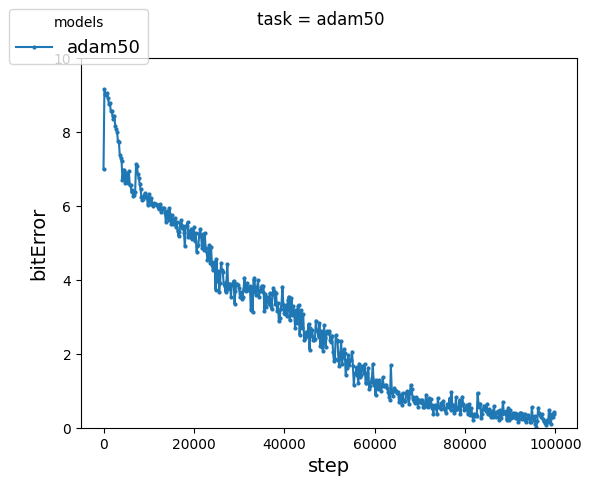

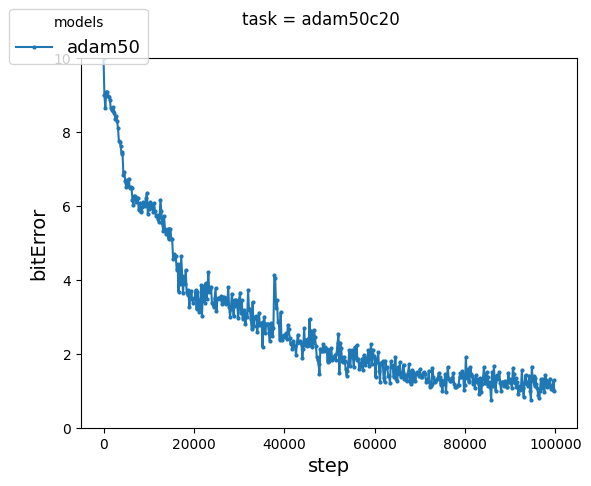

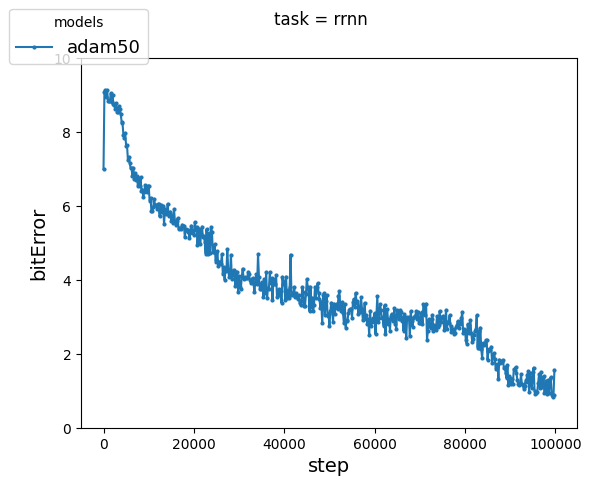

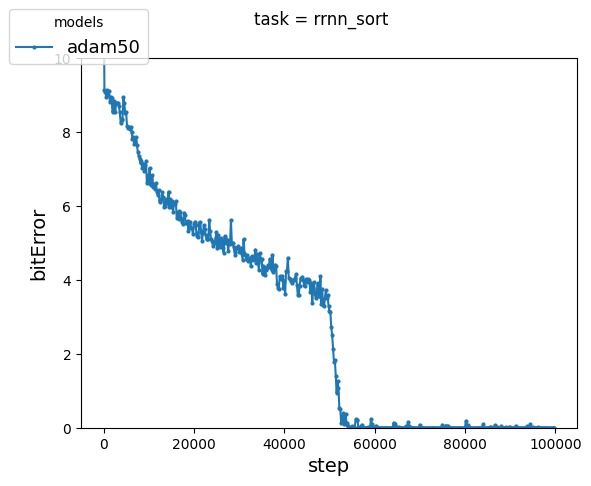

In [18]:
xlabel,ylabel="step","bitError"

baselinesloader =BaselinesLoader(baseline_config["filenames"])
bases =baselinesloader.get_data_dic()
for task,data in accSequence_df.iterrows():
    png_path=os.path.join(vis_config["savedir"],vis_config["savefile_common"]+task+".png")

    fig1 = plt.figure()

    ax1 = fig1.add_subplot(111)
    #ax1.set_xlim(left=0)
    ax1.set_ylim(0, 10)
    ax1.set_xlabel(xlabel,fontsize=14)
    ax1.set_ylabel(ylabel,fontsize=14)

    ##for ind_base,base_name in enumerate(baseline_config["filenames"]):
    ##    ax1.axhline(y=bases[base_name][task],color=baseline_config["base_colors"][ind_base]) #~label
    

    for ind,label in enumerate(readSS_config["read_directories"]):
        x=data[label][xlabel]
        y=data[label][ylabel]
        ax1.plot(x,y,marker=".",label=vis_config["model_labels"][ind],markersize=4) #ls linestyle

    handles, labels = ax1.get_legend_handles_labels()
    fig1.legend(handles, labels,title="models",fontsize=13,loc='upper left')
    #plt.legend(h1+h2, l1+l2)
    fig1.suptitle('task = '+task)
    
    fig1.savefig(png_path,bbox_inches="tight")